In [ ]:
# install detectron2
#수정x

!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

!gcc --version
%cd /content/
!git clone https://github.com/facebookresearch/detectron2
%cd /content/detectron2
!pip install -r requirements.txt
!python setup.py install
!pip install git+https://github.com/facebookresearch/fvcore.git

TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html

In [189]:
#import module
#수정x


import torch
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from PIL import Image
from torch.nn.utils.rnn import pad_sequence
import json


from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.modeling import build_model, build_backbone
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.utils.visualizer import Visualizer
import detectron2.data.transforms as T

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools.mask import encode

import skimage.io as io
import pylab

import tensorflow
import numpy

In [ ]:
# download training model(mask_rcnn)
#수정x

image_idx = 0 
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

model = build_model(cfg)
DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)
model.eval()

In [173]:
#dataset load(Google dirve)
#구글 드라이브에 있는 100개의 이미지 파일과 json파일을 사용
#수정o : 코드 추가(예시 이미지 보여주는 코드 추가)

from google.colab import drive
drive.mount('/content/drive')                                       #mount google drive

dataDir='/content/drive/MyDrive/val2017'                            #image file location
dataType='val2017'                                      
annFile='{}/instances_{}.json'.format(dataDir,dataType)             #json file location
coco=COCO(annFile)                                                  #coco api class

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
loading annotations into memory...
Done (t=1.79s)
creating index...
index created!


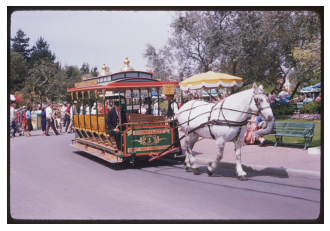

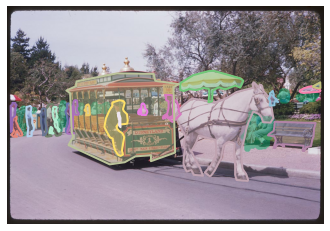

In [174]:
#show data example 
#데이터 중 16228이름을 가진 jpg 파일을 가져와 보여줌
#수정o 코드 추가(예시 이미지 보여주는 코드 추가)

imgIds = coco.getImgIds(imgIds = [16228])                          #image id(jpg file name)
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]   #image load

I = io.imread(img['coco_url']) 
plt.axis('off') 
plt.imshow(I) 
plt.show()                                                         #show image 

plt.imshow(I); 
plt.axis('off') 
annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None) 
anns = coco.loadAnns(annIds) 
coco.showAnns(anns)                                                #show image and annotation

In [204]:
#dataset register 
#수정o (image file name 변경)

"""
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset", {}, "instances_val2017.json", "/content/drive/MyDrive/val2017")
"""

#수정1 : dataset 이미지 파일 이름에 맞게 값 수정
image_files = ['006818', '016228', '017627', '025560', '035197', '037777', '039956', '041888', '058636', '063154']
image_files.extend(['066523', '479155', '080671', '085329', '087038', '104612', '109798', '122745', '125211', '142092'])
image_files.extend(['143931', '153299', '173383', '174482', '180135', '180560', '181666', '184321', '184791', '185250'])
image_files.extend(['199551', '100238', '219578', '226111', '496409', '233771', '238866', '239274', '239347', '252219'])
image_files.extend(['266409', '270244', '286994', '289393', '296649', '297343', '301867', '303818', '308394', '312421'])
image_files.extend(['314294', '321214', '322864', '329323', '331352', '336587', '347693', '348881', '349860', '355257'])
image_files.extend(['356427', '360661', '369370', '370677', '382088', '386912', '397133', '400573', '403385', '403817'])
image_files.extend(['418281', '430961', '438862', '443303', '448365', '456496', '458054', '460347', '463730', '473237'])
image_files.extend(['474028', '475779', '476258', '480985', '486438', '491497', '500663', '502136', '502737', '511321'])
image_files.extend(['514508', '515445', '515579', '516316', '522713', '555705', '562121', '565778', '572517', '577539'])

Image_ex = cv2.imread('/content/drive/MyDrive/val2017/000000' + '006818' + '.jpg')
print(Image_ex)
#수정1 끝

[[[139 125 106]
  [158 145 123]
  [161 147 124]
  ...
  [  7   5   4]
  [  7   6   2]
  [  7   7   1]]

 [[141 129 105]
  [165 154 127]
  [178 166 138]
  ...
  [  8   6   5]
  [  8   7   3]
  [  8   8   2]]

 [[139 128 100]
  [162 151 121]
  [176 165 133]
  ...
  [  6   4   3]
  [  6   5   1]
  [  6   6   0]]

 ...

 [[ 82  56  42]
  [ 84  58  44]
  [ 86  60  46]
  ...
  [ 22  14  14]
  [ 16  11   8]
  [ 11   8   4]]

 [[ 83  57  41]
  [ 84  58  42]
  [ 85  59  43]
  ...
  [ 18  13  12]
  [ 14  10   9]
  [ 10   9   5]]

 [[ 86  57  42]
  [ 85  59  43]
  [ 85  59  43]
  ...
  [ 16  11  12]
  [ 13   9   8]
  [ 10   9   5]]]


In [192]:
#feature extract 
#0~99 files에 feature extracting 수행, npy파일로 변경 후 저장
#수정o

aug = T.ResizeShortestEdge([cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST)   #image resize

for iter in range(0, 100):                                                                                #iter 0~99(images)
  
  image_file_number = image_files[iter]   

  image = cv2.imread('/content/drive/MyDrive/val2017/000000' + image_file_number + '.jpg')

  height, width = image.shape[:2]
  image = aug.get_transform(image).apply_image(image)
  image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
  inputs = [{"image": image, "height": height, "width": width}]                                           #model.preprocess의 input data 형식 맞추기
  
  with torch.no_grad():
      images = model.preprocess_image(inputs)                                                             #이미지 전처리                                                               
      features = model.backbone(images.tensor)                                                            #feature extract

  #수정1 : 코드 추가(feature을 p2,p3,p4,p5,p6로 저장)
  p2_feature_original = features['p2'].to("cpu")
  p3_feature_original = features['p3'].to("cpu")
  p4_feature_original = features['p4'].to("cpu")
  p5_feature_original = features['p5'].to("cpu")
  p6_feature_original = features['p6'].to("cpu")  
  #수정1 끝                                                        

  #수정2 : 코드 추가(추출된 feature을 numpy형식으로 변경)
  p2_numpy = p2_feature_original.numpy()
  p3_numpy = p3_feature_original.numpy()
  p4_numpy = p4_feature_original.numpy()
  p5_numpy = p5_feature_original.numpy()
  p6_numpy = p6_feature_original.numpy()                                                                 
  #수정2 끝

  #수정2 : 코드 추가(numpy파일을 구글 드라이브에 저장)
  np.save('/content/drive/MyDrive/save_feature/000000' + image_file_number + '_p2.npy', p2_numpy)
  np.save('/content/drive/MyDrive/save_feature/000000' + image_file_number + '_p3.npy', p3_numpy)
  np.save('/content/drive/MyDrive/save_feature/000000' + image_file_number + '_p4.npy', p4_numpy)
  np.save('/content/drive/MyDrive/save_feature/000000' + image_file_number + '_p5.npy', p5_numpy)
  np.save('/content/drive/MyDrive/save_feature/000000' + image_file_number + '_p6.npy', p6_numpy) 
  #수정3 끝
  """

"\n  #수정2 : 코드 추가(추출된 feature을 numpy형식으로 변경)\n  p2_numpy = p2_feature_original.numpy()\n  p3_numpy = p3_feature_original.numpy()\n  p4_numpy = p4_feature_original.numpy()\n  p5_numpy = p5_feature_original.numpy()\n  p6_numpy = p6_feature_original.numpy()                                                                 \n  #수정2 끝\n\n  #수정2 : 코드 추가(numpy파일을 구글 드라이브에 저장)\n  np.save('/content/drive/MyDrive/save_feature/000000' + image_file_number + '_p2.npy', p2_numpy)\n  np.save('/content/drive/MyDrive/save_feature/000000' + image_file_number + '_p3.npy', p3_numpy)\n  np.save('/content/drive/MyDrive/save_feature/000000' + image_file_number + '_p4.npy', p4_numpy)\n  np.save('/content/drive/MyDrive/save_feature/000000' + image_file_number + '_p5.npy', p5_numpy)\n  np.save('/content/drive/MyDrive/save_feature/000000' + image_file_number + '_p6.npy', p6_numpy) \n  #수정3 끝\n  "

In [207]:
#inference
#수정 o

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools.mask import encode

for iter in range(0, 100):

  image_idx = iter
  image_file_number = image_files[image_idx]

  #수정1 : 코드 추가(드라이브에 저장된 feature을 불러옴)
  with torch.no_grad():
      p2_numpy = np.load('/content/drive/MyDrive/save_feature/000000' + image_file_number + '_p2.npy')
      p3_numpy = np.load('/content/drive/MyDrive/save_feature/000000' + image_file_number + '_p3.npy')
      p4_numpy = np.load('/content/drive/MyDrive/save_feature/000000' + image_file_number + '_p4.npy')
      p5_numpy = np.load('/content/drive/MyDrive/save_feature/000000' + image_file_number + '_p5.npy')
      p6_numpy = np.load('/content/drive/MyDrive/save_feature/000000' + image_file_number + '_p6.npy')
  #수정1 끝

  #수정2 : 코드 추가(feature을 tensor형식으로 변경)
      p2_feature_original = torch.tensor(p2_numpy)
      p3_feature_original = torch.tensor(p2_numpy)
      p4_feature_original = torch.tensor(p2_numpy)
      p5_feature_original = torch.tensor(p2_numpy)
      p6_feature_original = torch.tensor(p2_numpy)
  #수정2 끝

  #수정3 : 코드 추가(feature을 cuda형식으로 변경)
      p2_cuda = p2_feature_original.to(torch.device("cuda"))
      p3_cuda = p3_feature_original.to(torch.device("cuda"))
      p4_cuda = p4_feature_original.to(torch.device("cuda"))
      p5_cuda = p5_feature_original.to(torch.device("cuda"))
      p6_cuda = p6_feature_original.to(torch.device("cuda"))
  #수정3 끝

      images = model.preprocess_image(inputs)                                                              # 이미지 후 처리
      features = model.backbone(images.tensor)                                                             # feature extract
      features['p2'] = p2_cuda
      features['p3'] = p3_cuda
      features['p4'] = p4_cuda
      features['p5'] = p5_cuda
      features['p6'] = p6_cuda                                                                             #불러온 feature로 feature map변경
      proposals, _ = model.proposal_generator(images, features, None)                                      #RPN 수행
  
  ##헷갈리는 부분1##
  #아래 코드에서 ROI를 수행한 후
      features_ = [features[f] for f in model.roi_heads.box_in_features]
      box_features = model.roi_heads.box_pooler(features_, [x.proposal_boxes for x in proposals])
      box_features = model.roi_heads.box_head(box_features)  
  #\아래 부분에서 classfication을 수행하는 것 같은데 구체적으로 함수들이 어떤 과정을 수행하는 지 잘 모르겠습니다.
      predictions = model.roi_heads.box_predictor(box_features)
      pred_instances, pred_inds = model.roi_heads.box_predictor.inference(predictions, proposals)
      pred_instances = model.roi_heads.forward_with_given_boxes(features, pred_instances)                     

      pred_instances = model._postprocess(pred_instances, inputs, images.image_sizes)                        # scale box to orig size
  #헷갈리는 부분1 끝
      feats = box_features[pred_inds]

  pred_category = pred_instances[0]["instances"].pred_classes.to("cpu")
  pred_segmentation = pred_instances[0]["instances"].pred_masks.to("cpu")
  pred_score = pred_instances[0]["instances"].scores.to("cpu")                                                #inference

  xxx = pred_category
  xxx = xxx.numpy()

  #수정4 : 코드 삭제(coco object classfication category 변경 코드 삭제) 
'''
  xxx = xxx + 1

  for idx in range(len(xxx)):
      if -1 < int(xxx[idx]) < 12:
        xxx[idx] = xxx[idx]
      elif 11 < int(xxx[idx]) < 25:
        xxx[idx] = xxx[idx] + 1
      elif 24 < int(xxx[idx]) < 27:
        xxx[idx] = xxx[idx] + 2
      elif 26 < int(xxx[idx]) < 41:
        xxx[idx] = xxx[idx] + 4
      elif 40 < int(xxx[idx]) < 61:
        xxx[idx] = xxx[idx] + 5
      elif 60 < int(xxx[idx]) < 62:
        xxx[idx] = 67
      elif 61 < int(xxx[idx]) < 63:
        xxx[idx] = 70
      elif 62 < int(xxx[idx]) < 74:
        xxx[idx] = xxx[idx] + 9
      else:
        xxx[idx] = xxx[idx] + 10
  '''

 #수정 4끝 

  imgID = int(image_file_number)
  if image_idx == 0:
    anns = []
  else:
    anns = anns

  for idx in range(len(pred_category.numpy())):                                                             #결과 값 image_id, category_id, segmentation, score값을 anns(resFile)로 저장

    anndata = {}
    anndata['image_id'] = int(imgID)
    anndata['category_id'] = int(xxx[idx])
    anndata['segmentation'] = encode(np.asfortranarray(pred_segmentation[idx].numpy()))
    anndata['score'] = float(pred_score[idx].numpy())
    anns.append(anndata)

#수정 5 코드 삭제
#image_idx = image_idx + 1

In [208]:
#json파일이 제대로 등록되어 있는지 확인
#수정1 : 테스트 코드 추가
print(anns[0], '\n')

annsImgIds = [ann['image_id'] for ann in anns]
annsImgIds = set(annsImgIds)     #예측 값의 id
print(sorted(annsImgIds))

cocogt = set(cocoGt.getImgIds()) #참 값의 id, json기반
print(sorted(cocogt))

image_name = list(range(100))
for i in range(100):
  image_name[i] = int(image_files[i])
image_name = set(image_name)     #코드로 쓰여진 id

test = sorted(annsImgIds - cocogt)
print(image_name, '\n')

#json파일과 코드로 쓴 이미지 id의 차이가 남
#json파일을 잘못 작성
print(image_name - cocogt)        #빈 값일 경우 정상
print(cocogt - image_name)
#수정1 끝

print(cocoDt.anns)

{'image_id': 16228, 'category_id': 0, 'segmentation': {'size': [334, 500], 'counts': b'mfQ26W:1O1O1L5N1O1001O1O5K002MVTm2'}, 'score': 0.9731200337409973} 

[16228, 17627, 35197, 37777, 87038, 100238, 104612, 125211, 173383, 174482, 181666, 185250, 233771, 239274, 252219, 286994, 296649, 303818, 312421, 322864, 336587, 348881, 349860, 370677, 386912, 397133, 403385, 430961, 438862, 460347, 463730, 474028, 479155, 480985, 491497, 496409, 500663, 502136, 511321, 515445, 522713, 565778, 572517]
[6818, 16228, 17627, 25560, 35197, 37777, 39956, 41888, 58636, 63154, 66523, 80671, 85329, 87038, 100238, 104612, 109798, 122745, 125211, 142092, 143931, 153299, 173383, 174482, 180135, 180560, 181666, 184321, 184791, 185250, 199551, 219578, 226111, 233771, 238866, 239274, 239347, 252219, 266409, 270244, 286994, 289393, 296649, 297343, 301867, 303818, 308394, 312421, 314294, 321214, 322864, 329323, 331352, 336587, 347693, 348881, 349860, 355257, 356427, 360661, 369370, 370677, 382088, 386912, 397133

In [211]:
#evaluation
#수정o 

annType = ['segm','bbox','keypoints']
annType = annType[0]                                                        #annotation형식을 segmentation으로 설정
prefix = 'instances'
print('Running demo for *%s* results.'%(annType)) 

#수정1 : 경로 변경, 
dataDir='/content/drive/MyDrive/val2017'
dataType='val2017'
annFile='{}/instances_{}.json'.format(dataDir,dataType)
cocoGt = COCO(annFile)
#수정1 끝

resFile = anns                                                            #{'image_id': 16228, ... 'score': 0.9731200337409973}과 같은 inferece값

cocoDt = cocoGt.loadRes(resFile)                                           #laodRes : annotation정보를 input값으로 받아 알고리즘 결과를 출력하는 api                            

cocoEval = COCOeval(cocoGt,cocoDt,annType)                                 #cocoGt : 참값,  cocoDt : 탐지값
cocoEval.evaluate()                                                        #evaluation
cocoEval.accumulate()
cocoEval.summarize()

Running demo for *segm* results.
loading annotations into memory...
Done (t=0.83s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.29s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=

In [196]:
##################################################################################################################################################################
##원본 코드##


from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools.mask import encode

image_files = ['001000', '002153', '008021', '009769', '009891', '015335', '017627', '018150', '018837', '022589']
image_files.extend(['022935', '023230', '024610', '025560', '025593', '027620', '155341', '161397', '165336', '166287'])
image_files.extend(['166642', '169996', '172330', '172648', '176606', '176701', '179765', '180101', '186296', '250758'])
image_files.extend(['259382', '267191', '287545', '287649', '289741', '293245', '308328', '309452', '335529', '337987'])
image_files.extend(['338625', '344029', '350122', '389933', '393226', '395343', '395633', '401862', '402473', '402992'])
image_files.extend(['404568', '406997', '408112', '410650', '414385', '414795', '415194', '415536', '416104', '416758'])
image_files.extend(['427055', '428562', '430073', '433204', '447200', '447313', '448448', '452321', '453001', '458755'])
image_files.extend(['462904', '463522', '464089', '468965', '469192', '469246', '471450', '474078', '474881', '475678'])
image_files.extend(['475779', '537802', '542625', '543043', '543300', '543528', '547502', '550691', '553669', '567740'])
image_files.extend(['570688', '570834', '571943', '573391', '574315', '575372', '575970', '578093', '579158', '581100'])


for iter in range(0, 100):

  image_file_number = image_files[image_idx]

  # [6]
  aug = T.ResizeShortestEdge(
    [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
  #  [480, 480], cfg.INPUT.MAX_SIZE_TEST
  #  [768, 768], cfg.INPUT.MAX_SIZE_TEST
  )

  image = cv2.imread('./validset_100/000000'+ image_file_number +'.jpg')  # insert images
  height, width = image.shape[:2]
  image = aug.get_transform(image).apply_image(image)
  image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
  inputs = [{"image": image, "height": height, "width": width}]

  # [21]
  with torch.no_grad():
      images = model.preprocess_image(inputs)  # don't forget to preprocess
      features = model.backbone(images.tensor)  # set of cnn features
      features['p2'] = p2_cuda
      features['p3'] = p3_cuda
      features['p4'] = p4_cuda
      features['p5'] = p5_cuda
      features['p6'] = p6_cuda
      proposals, _ = model.proposal_generator(images, features, None)  # RPN

      features_ = [features[f] for f in model.roi_heads.box_in_features]
      box_features = model.roi_heads.box_pooler(features_, [x.proposal_boxes for x in proposals])
      box_features = model.roi_heads.box_head(box_features)  # features of all 1k candidates
      predictions = model.roi_heads.box_predictor(box_features)
      pred_instances, pred_inds = model.roi_heads.box_predictor.inference(predictions, proposals)
      pred_instances = model.roi_heads.forward_with_given_boxes(features, pred_instances)

      # output boxes, masks, scores, etc
      pred_instances = model._postprocess(pred_instances, inputs, images.image_sizes)  # scale box to orig size
      # features of the proposed boxes
      feats = box_features[pred_inds]

  # [26]
  pred_category = pred_instances[0]["instances"].pred_classes.to("cpu")
  pred_segmentation = pred_instances[0]["instances"].pred_masks.to("cpu")
  pred_score = pred_instances[0]["instances"].scores.to("cpu")

  # [27]
  xxx = pred_category
  xxx = xxx.numpy()

  # [28]
  xxx = xxx + 1

  # [29]
  for idx in range(len(xxx)):
      if -1 < int(xxx[idx]) < 12:
        xxx[idx] = xxx[idx]
      elif 11 < int(xxx[idx]) < 25:
        xxx[idx] = xxx[idx] + 1
      elif 24 < int(xxx[idx]) < 27:
        xxx[idx] = xxx[idx] + 2
      elif 26 < int(xxx[idx]) < 41:
        xxx[idx] = xxx[idx] + 4
      elif 40 < int(xxx[idx]) < 61:
        xxx[idx] = xxx[idx] + 5
      elif 60 < int(xxx[idx]) < 62:
        xxx[idx] = 67
      elif 61 < int(xxx[idx]) < 63:
        xxx[idx] = 70
      elif 62 < int(xxx[idx]) < 74:
        xxx[idx] = xxx[idx] + 9
      else:
        xxx[idx] = xxx[idx] + 10

  # [30]
  imgID = int(image_file_number)
  if image_idx == 0:
    anns = []
  else:
    anns = anns

  for idx in range(len(pred_category.numpy())):

    anndata = {}
    anndata['image_id'] = imgID
    anndata['category_id'] = int(xxx[idx])
      
    anndata['segmentation'] = encode(np.asfortranarray(pred_segmentation[idx].numpy()))
    anndata['score'] = float(pred_score[idx].numpy())
    anns.append(anndata)

  image_idx = image_idx + 1

annType = ['segm','bbox','keypoints']
annType = annType[0]      #specify type here
prefix = 'instances'
print('Running demo for *%s* results.'%(annType)) 
# imgIds = [560474]
annFile = './instances_val2017_dataset100.json'
cocoGt=COCO(annFile)

#initialize COCO detections api
resFile = anns
cocoDt=cocoGt.loadRes(resFile)

# running evaluation
cocoEval = COCOeval(cocoGt,cocoDt,annType)
# cocoEval.params.imgIds  = imgIds
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

AttributeError: ignored